In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
df = pd.read_csv('data.csv')
print(df.shape)

(78682, 21)


In [13]:
# Params
ranges = [4, 20]
horizon = 1
min_sequence_length = 4
max_sequence_length = 10
exclude_cols = ['company_name', 'year', 'status_label', 'X16'] # X16 has been filtered out earlier
feature_cols = [col for col in df.columns if col not in exclude_cols]

In [14]:
df.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [15]:
df.describe()

,year,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
count,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,7.868200e+04,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000,78682.000000
mean,2007.506317,880.362485,1594.529029,121.234256,376.759424,201.605717,129.382453,286.832743,3.414355e+03,2364.019706,2867.110620,722.483710,255.525035,769.490783,610.072255,532.467069,2364.019706,1773.563963,1987.260307
std,5.742768,3928.564794,8930.484664,652.376804,2012.023142,1060.766096,1265.532022,1335.978571,1.841410e+04,11950.068842,12917.944421,3242.170946,1494.643534,3774.703114,2938.387443,6369.159440,11950.068842,8053.684902,10419.629038
min,1999.000000,-7.760000,-366.645000,0.000000,-21913.000000,0.000000,-98696.000000,-0.006000,1.000000e-04,-1964.999000,0.001000,-0.023000,-25913.000000,-21536.000000,0.001000,-102362.000000,-1964.999000,0.001000,-317.197000
25%,2002.000000,18.924000,17.038250,1.192000,-0.811000,0.000000,-7.415750,3.281250,3.498000e+01,27.548500,37.363500,0.000000,-2.787000,8.521250,8.889250,-68.282750,27.548500,13.486000,32.872500
50%,2007.000000,100.449500,103.661000,7.929500,15.034500,7.023000,1.616000,22.820000,2.275118e+02,186.598500,213.203500,7.593500,6.518000,63.581500,43.333000,-1.131000,186.598500,81.988000,168.912000
75%,2012.000000,431.526750,634.548000,47.971750,139.655250,74.747250,40.144250,131.580500,1.244890e+03,1046.402500,1171.364750,248.760750,87.599000,344.074250,222.817000,146.070000,1046.402500,629.975000,875.522250
max,2018.000000,169662.000000,374623.000000,28430.000000,81730.000000,62567.000000,104821.000000,65812.000000,1.073391e+06,511729.000000,531864.000000,166250.000000,71230.000000,137106.000000,116866.000000,402089.000000,511729.000000,337980.000000,481580.000000


In [16]:
# Encode status_label with 1 for failed and 0 for alive
df['status_label'] = df['status_label'].map({'failed': 1, 'alive': 0})
# Encode company_name with leading zeros
df['company_name'] = df['company_name'].apply(lambda x: 'C_' + x.split('_')[1].zfill(4))
# Encode years to counters
df['year'] = (
    df.groupby('company_name')['year']
      .transform(lambda x: pd.Series(pd.factorize(x.sort_values())[0] + 1, index=x.sort_values().index).reindex(x.index))
)

In [17]:
# Checking for, if the bankrupt label changes at any point for a company
label_changed_companies = (
    df.groupby('company_name')['status_label']
    .nunique()
    .reset_index()
)

label_changed_companies = label_changed_companies[label_changed_companies['status_label'] > 1]

if len(label_changed_companies['company_name'].tolist()) == 0:
    print('The status label doesnt change for any company.')
else:
    print(label_changed_companies['company_name'].tolist())

The status label doesnt change for any company.


failed and alive ratio for 4 years:
status_label
0    2580
1     144
Name: count, dtype: int64
Alive:    645
Bankrupt: 36
Ratio:    18.9167

failed and alive ratio for 5 years:
status_label
0    2820
1     260
Name: count, dtype: int64
Alive:    564
Bankrupt: 52
Ratio:    11.8462

failed and alive ratio for 6 years:
status_label
0    2988
1     450
Name: count, dtype: int64
Alive:    498
Bankrupt: 75
Ratio:    7.6400

failed and alive ratio for 7 years:
status_label
0    3094
1     385
Name: count, dtype: int64
Alive:    442
Bankrupt: 55
Ratio:    9.0364

failed and alive ratio for 8 years:
status_label
0    2960
1     456
Name: count, dtype: int64
Alive:    370
Bankrupt: 57
Ratio:    7.4912

failed and alive ratio for 9 years:
status_label
0    3060
1     558
Name: count, dtype: int64
Alive:    340
Bankrupt: 62
Ratio:    6.4839

failed and alive ratio for 10 years:
status_label
0    2230
1     420
Name: count, dtype: int64
Alive:    223
Bankrupt: 42
Ratio:    6.3095

failed and alive 

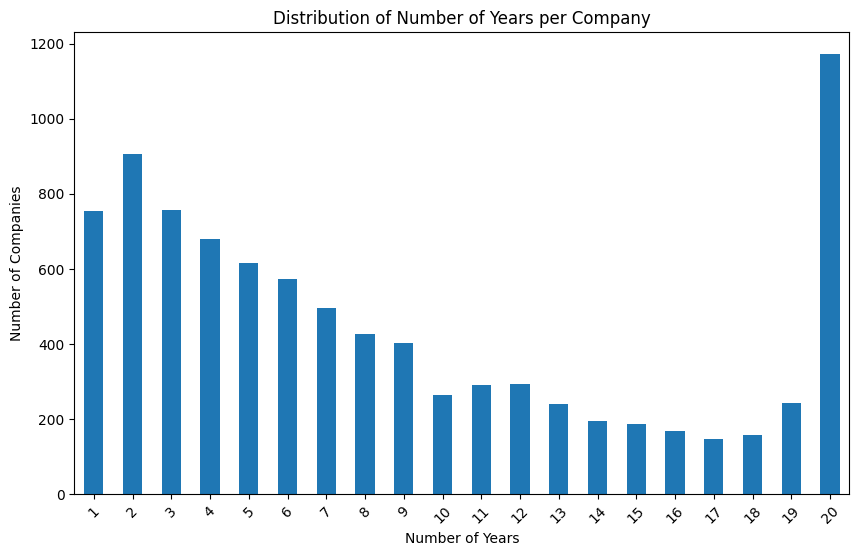

Alive:    8362
Bankrupt: 609
Ratio:    14.7307

Ratio of eventually bankrupt and alive companies: 14.730706075533663


In [18]:
# Verify distribution of data based on time series length
# Verify ratio of eventually bankrupt companies

def count_eventually_bankrupt(df):
    company_groups = df.groupby('company_name')
    
    bankrupt_companies = company_groups['status_label'].apply(lambda x: (x == 1).any())
    
    num_bankrupt = bankrupt_companies.sum()
    num_alive = len(bankrupt_companies) - num_bankrupt
    ratio = (num_alive + num_bankrupt) / num_bankrupt
    
    print(f"Alive:    {num_alive}")
    print(f"Bankrupt: {num_bankrupt}")
    print(f"Ratio:    {ratio:.4f}\n")

    return ratio

for i in range(ranges[0], ranges[1]+1):
    test_df = df.groupby('company_name').filter(lambda x: len(x) == i)
    print('failed and alive ratio for ' + str(i) + ' years:')
    print(test_df['status_label'].value_counts())
    count_eventually_bankrupt(test_df)

company_year_counts = df.groupby('company_name')['year'].nunique()

# Plot the distribution of the number of years
plt.figure(figsize=(10, 6))
company_year_counts.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Number of Years per Company')
plt.xlabel('Number of Years')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.show()

print(f"Ratio of eventually bankrupt and alive companies: {count_eventually_bankrupt(df)}")


In [19]:
# The label doesnt change for any company, indicating a subsequent prediction
# A company is labeled as bankrupt in the next year, if the last recorded year states bankrupt
# So, create a prediction horizon for the next two years by changing every but the last two labels to alive
# Sort out companies where we have less than 4 years of data
df = df.groupby('company_name').filter(lambda x: len(x) >= min_sequence_length)

df = df.sort_values(by=['company_name', 'year'])

# For each company, assign 1 if bankruptcy occurs in year T+1 or T+2
for company, group in df.groupby('company_name'):
    if group['status_label'].nunique() == 1 and group['status_label'].iloc[0] == 1:
        # All years labeled as bankrupt — assume future event
        idxs = group.sort_values('year').index
        # Set all to 0 (normal)
        df.loc[idxs, 'status_label'] = 0
        # Optionally set last 1 or 2 years to 1 (T–1/T–2 window)
        for i in range(1, horizon+1):
            df.loc[idxs[-i], 'status_label'] = 1

print(df['status_label'].value_counts())
counts = df['status_label'].value_counts()
ratio = counts[0] / counts[1]
print(f"Label ratio: {ratio}")
count_eventually_bankrupt(df)
df_sorted = df.sort_values(by=['status_label', 'company_name', 'year'], ascending=[False, True, True])
df_sorted[['company_name', 'status_label', 'year']].head()

# There exists a strong imbalance within the bankruptcy labels, yet oversampling might hurt 
# the realistic data of the dataset, so training weights will rather be applied to maintain
# a realistic evaluation and still not overfit to the alive companies.

status_label
0    73306
1      541
Name: count, dtype: int64
Label ratio: 135.50092421441775
Alive:    6013
Bankrupt: 541
Ratio:    12.1146



,company_name,status_label,year
61,C_0006,1,12
192,C_0014,1,20
256,C_0020,1,18
465,C_0038,1,6
595,C_0053,1,5


In [20]:
# Transform the data into logdiff per company
# Sort the DataFrame to ensure correct time ordering
df = df.sort_values(by=['company_name', 'year'])

epsilon = 1e-5 # To avoid log(0)

# Usage of signed logdiff since also negative values need to be handled
def signed_log_diff(series):
    signed_log = np.sign(series) * np.log(np.abs(series) + epsilon)
    return signed_log.diff()

df[feature_cols] = df.groupby('company_name')[feature_cols].transform(signed_log_diff).fillna(0)
df = df.drop(columns=['X16'])

df.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X17,X18
0,C_0001,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,C_0001,0,2,-0.050980,-0.154544,0.011042,-0.324384,-0.047002,-0.640549,-0.108188,0.011645,-0.158425,-0.054273,-0.002552,-0.433786,-0.175511,-0.267299,0.015004,-0.104510,-0.143974
2,C_0001,0,3,-0.106767,-0.304411,0.191413,-0.861127,-0.112117,-6.995949,-0.395918,-0.033777,-0.313904,0.011820,0.190229,-2.274164,-0.357270,0.182279,-0.379636,0.100720,-0.280958
3,C_0001,0,4,-0.096692,-0.058127,0.188849,0.122253,-0.097541,1.558000,-0.156117,-0.933635,-0.052032,-0.033763,-0.279243,-0.276494,-0.023929,0.302311,-0.117667,-0.021049,-0.060539
4,C_0001,0,5,0.086444,0.052078,-0.018273,0.434813,-0.050125,3.772411,0.456205,0.767894,0.072544,0.032485,0.412240,1.762074,0.160396,-0.438847,0.060787,0.039981,0.048948


In [21]:
# Transforming the dataset into sequences for each respective company
sequences = []
grouped = df.groupby('company_name')

for company, group in grouped:
    group = group.sort_values('year')
    available_length = len(group)  # Length of sequence based on available data

    sequence_length = min(available_length, max_sequence_length)
    
    features = group[feature_cols].values[-sequence_length:]  # Get the last `sequence_length` rows of features
    labels = group['status_label'].values[-sequence_length:]
    label = 1 if any(l == 1 for l in labels[-horizon:]) else 0 # Sets sequence label
    sequences.append((features, label))

In [22]:
# Make sequences model-ready
X_raw = [seq[0] for seq in sequences]
y = np.array([seq[1] for seq in sequences])

# Pad all sequences to the same length (requires masking in LSTM)
X_padded = pad_sequences(X_raw, padding='pre', dtype='float32')

print(X_padded.shape) 
print(y.shape)

X = X_padded

(6554, 10, 17)
(6554,)
